<a href="https://colab.research.google.com/github/ykato27/First-Order-Motion-Model-example/blob/main/First_Order_Motion_Model_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 写真の表情・姿勢を操作するレシピ

### first-order-model
- 今回使用するコードは [First Order Motion Model for Image Animation](https://papers.nips.cc/paper/2019/file/31c0b36aef265d9221af80872ceb62f9-Paper.pdf) という論文で提案されたアルゴリズムです。

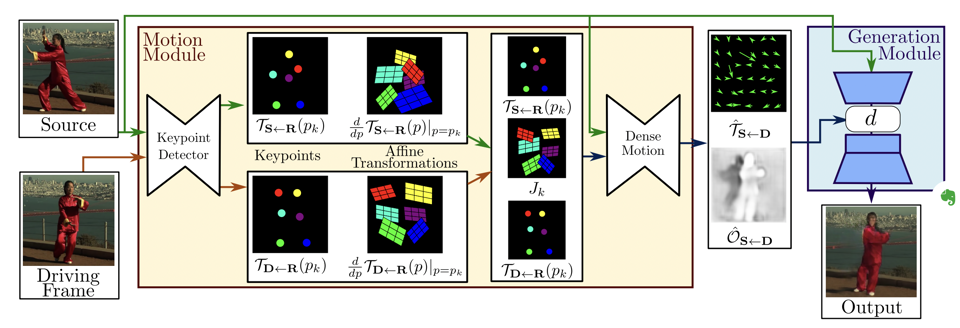

- アルゴリズムは大きく分けて Motion Module と Generation Module の2つで構成されています。入力は、静止画 source と、動画 Driving Frame です。
- Motion Module は、静止画と動画の各フレームそれぞれに対して、キーポイント位置(顔の場合なら目、鼻、口、顔の輪郭など)、キーポイントにおける勾配を、Reference画像(図ではRと表示)を基準として計算します。
- そして、そのキーポイント計算とヤコビアンJk(静止画と動画フレームの大きさの比率)から、動画の各フレームの画素を静止画のどの画素から作れば良いかを示すマッピング関数を計算します。
- この様に静止画と動画の各フレームの差を計算するのではなく、Reference画像という概念的な基準画像との差を計算することで静止画と動画の各フレームが独立に計算出来、両者の画像の差が大きくても上手く変換ができます。
- また、静止画を動かすとそもそも静止画に含まれていない部分が発生しますが、それを上手く処理するオクルージョン(Oで表示)という処理を行っています。
- Generation Module は、それらの結果と静止画から、画像を出力します。損失関数は、静止画と出力画像の誤差＋正則化項(マッピング関数が単純な変換に近くなるような拘束条件)です。
- 学習時は、静止画と動画は同一の動画から任意のフレームを選択して行います。推論時は、学習時と同じカテゴリーであれば静止画と動画とも任意のもので行えます。

- first-order-modelに関する理論詳細は、以下の資料をご確認ください。
- 論文 : https://papers.nips.cc/paper/2019/file/31c0b36aef265d9221af80872ceb62f9-Paper.pdf
- 論文読解 ：https://qiita.com/takoroy/items/e4abfa305fda0066d470

### 環境の準備

In [ ]:
!git clone https://github.com/AliaksandrSiarohin/first-order-model
%cd first-order-model

Cloning into 'first-order-model'...
remote: Enumerating objects: 299, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 299 (delta 2), reused 2 (delta 0), pack-reused 293
Receiving objects: 100% (299/299), 72.15 MiB | 13.92 MiB/s, done.
Resolving deltas: 100% (153/153), done.
/content/first-order-model


In [ ]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage.transform import resize
from IPython.display import HTML
import warnings
warnings.filterwarnings("ignore")

### source imageとdriving video を用意

driving video をダウロード

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1PaOVqwPdnZkc5YzyqdL_ylCluave9xuU',
                                    dest_path='./04.mp4',
                                    unzip=False)

source image をダウロード

In [ ]:
gdd.download_file_from_google_drive(file_id='1GcG1g8IeJ0ooYqCO-s69S28fX68w5Rn7',
                                    dest_path='./02.png',
                                    unzip=False)

source imageとdriving video をロード

In [ ]:
source_image = imageio.imread('./02.png')
reader = imageio.get_reader('./04.mp4')

ource imageをリサイズ（256x256）。

In [ ]:
source_image = resize(source_image, (256, 256))[..., :3]

driving video も（256x256）にリサイズ

In [ ]:
fps = reader.get_meta_data()['fps']
driving_video = []
try:
    for im in reader:
        driving_video.append(im)
except RuntimeError:
    pass
reader.close()

driving_video = [resize(frame, (256, 256))[..., :3] for frame in driving_video]

def display(source, driving, generated=None):
    fig = plt.figure(figsize=(8 + 4 * (generated is not None), 6))

    ims = []
    for i in range(len(driving)):
        cols = [source]
        cols.append(driving[i])
        if generated is not None:
            cols.append(generated[i])
        im = plt.imshow(np.concatenate(cols, axis=1), animated=True)
        plt.axis('off')
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=1000)
    plt.close()
    return ani

source imageとdriving video を表示

In [ ]:
HTML(display(source_image, driving_video).to_html5_video())

### トレーニング済みモデルをダウンロード

トレーニング済みモデルをダウンロード

In [ ]:
gdd.download_file_from_google_drive(file_id='1PY3qv5qleFX0hGJ_fS5YYszPH2CoTCMN',
                                    dest_path='./vox-cpk.pth.tar',
                                    unzip=False)

トレーニング済みモデルをロード

In [ ]:
from demo import load_checkpoints
generator, kp_detector = load_checkpoints(config_path='config/vox-256.yaml', 
                            checkpoint_path='./vox-cpk.pth.tar')

### 静止画をアニメーションに変換

アニメーションを作成

In [ ]:
from demo import make_animation
from skimage import img_as_ubyte

predictions = make_animation(source_image, driving_video, generator, kp_detector, relative=True)

100%|██████████| 211/211 [00:40<00:00,  5.20it/s]


生成したアニメーションを保存

In [ ]:
imageio.mimsave('../generated.mp4', [img_as_ubyte(frame) for frame in predictions], fps=fps)

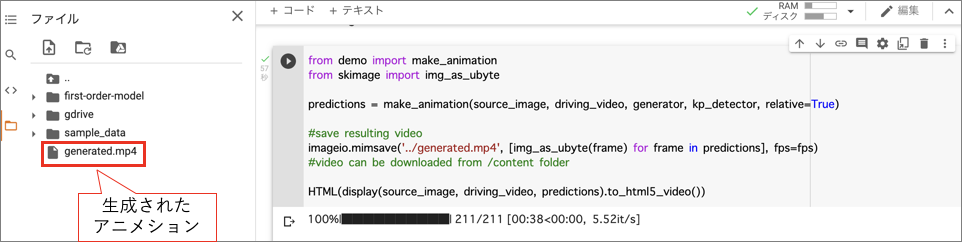

生成したアニメーションを表示

In [ ]:
HTML(display(source_image, driving_video, predictions).to_html5_video())